In [1]:
import chromadb
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceBgeEmbeddings, OpenAIEmbeddings
import glob
import re

In [8]:
text_files = glob.glob(r'./data/SOPs Nova/*.txt')
all_pages = []
for text in text_files:
    loader = TextLoader(text,  encoding='utf-8')
    pages = loader.load()
    all_pages.extend(pages)

In [17]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 10000,
    chunk_overlap = 200,
    separators = ['.', '\n'],
    add_start_index = True)

In [18]:
len(all_pages)

3

In [19]:
texts = text_splitter.split_documents(all_pages)
print (len(texts))

30


In [20]:
long_texts = []
for t in texts:
    if len(t.page_content) > 300:
        long_texts.append(t)
    else:
        print (t.page_content)
print (len(long_texts))

30


In [91]:
[len(x.page_content) for x in long_texts]

[9953,
 9830,
 9961,
 9646,
 9930,
 9892,
 9818,
 9898,
 9863,
 9836,
 9415,
 9812,
 9845,
 9891,
 9952,
 9977,
 9855,
 9749,
 9996,
 9513,
 9707,
 9929,
 9590,
 9661,
 8208,
 9990,
 9960,
 7200,
 9920,
 3039]

In [2]:
persist_directory = './chromadb_sops_nova/'
embed_path  = '/embeddings/'

In [3]:
embeddings = HuggingFaceBgeEmbeddings(model_name = 'BAAI/bge-large-en', cache_folder=embed_path)

In [92]:

collection_name = 'sops_nova_10000_200'
client = chromadb.PersistentClient(path= persist_directory)
db = Chroma(
    client=client,
    persist_directory=persist_directory,
    collection_name = collection_name,
    embedding_function=embeddings)

In [93]:
%%time
added_documents = db.add_documents(texts)
db.persist()

CPU times: total: 4min 10s
Wall time: 1min 4s


In [16]:
client.list_collections()

[Collection(name=sops_nova_1000_20),
 Collection(name=sops_nova),
 Collection(name=sops_nova_10000_200)]

In [5]:
question = 'What is impossible travel?'
answer  = db.similarity_search_with_score(question)

In [6]:
for doc, score in answer:
    print (doc.metadata, score)

{'source': './data/SOPs Nova\\MVP Runbook Ver 1.txt', 'start_index': 4648} 0.5201226472854614
{'source': './data/SOPs Nova\\MVP Runbook Ver 1.txt', 'start_index': 7779} 0.5416182279586792
{'source': './data/SOPs Nova\\MVP Runbook Ver 1.txt', 'start_index': 175638} 0.542321503162384
{'source': './data/SOPs Nova\\MVP Runbook Ver 1.txt', 'start_index': 20445} 0.5476157069206238


In [14]:
for doc, score in answer:
    print (doc.page_content, '\n\n')

.1	Use Case Mapping (To be filled by project teams)	139
58.2	Open-Source Tools	139
58.3	Key Windows Event IDs	139


 

1	Impossible Travel Activity/Unusual Remote Access

Objective: The objective of this use-case is to identify potential compromised user ids by detecting anomalous/suspicious authentications into the environment e.g., change in user login location.
False Positive Scenario:  User has travelled, is using VPN, connecting via two devices on different ISPs etc. In such cases check Host Names, Device IDs to identify if the login is from user’s usual device or from a new device.
Things to be Identified for confirmed Incidents
•	When and how did user’s credential got compromised?
•	Were there other users who could have been compromised similarly e.g., Click on same phish URL etc 


.?
o	Is the IP blacklisted/hosting suspicious Machine (Debian Linux)/belong to a hostile geo?
o	Is login happening out of hours?
o	Any suspicious activity detected by endpoint security agent/SIEM on 

## Generate Questions

In [7]:
import openai, os
from openai import OpenAI
import subprocess
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [36]:

question_generation_system_message_template = '''
You are a network security expert. 
You are given sections from cyber security documentation.
You are to generate {} meaningfull quesitons for each document. 
Do not generate questions if the document is just a table of content. Do not return anything.
Just generate the question, no explanation, just a single sentence question.
'''

In [72]:
number_questions = 15
question_generation_system_message_template.format(number_questions)

'\nYou are a network security expert. \nYou are given sections from cyber security documentation.\nYou are to generate 15 meaningfull quesitons for each document. \nDo not generate questions if the document is just a table of content. Do not return anything.\nJust generate the question, no explanation, just a single sentence question.\n'

In [37]:
model='gpt-4-turbo-preview'
temperature = 0
all_answers = []
number_questions = 2
for text in long_texts:

    new_content = text.page_content
    question_generation_system_message  = question_generation_system_message_template.format(number_questions)
    messages = []
    messages.append({"role": "system", "content": question_generation_system_message})
    
    messages.append({"role": "user", "content": new_content})

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens = 300
    )

    answer = response.choices[0].message.content
    all_answers.append(answer)

In [38]:
print (answer)

What steps should be taken if a recently published CVE with critical severity is identified in our environment?
How should bulk IP, URL, or Domain IOC's be managed and utilized for network traffic analysis?


In [59]:
none = [print (x) for x in all_answers]

For the section on "Impossible Travel Activity/Unusual Remote Access":
1. How can SOC teams differentiate between legitimate travel-related login attempts and actual impossible travel activity?
2. What steps should be taken if a user's device is identified as not belonging to them during the analysis of an impossible travel alert?

For the section on "Threat Intel Activity Detected/ Threat Intel Indicator Matched – IP Address":
1. What are the key indicators that a communication with a matched IP address is part of a malicious intrusion attempt rather than legitimate traffic?
2. How should SOC teams proceed when multiple systems in the environment have communicated with known IOCs?
For the section on External Unauthorized vulnerability scanning activity/Multiple Web Attack Detections from a Single IP/Multiple IPS/WAF Alerts detected on a Single Host in a short span of time:

1. How can the initial information gathering process be improved to quickly differentiate between false positive

In [64]:
all_questions = []
pattern = r"\b\d+\.\s(.*?\?)"

for text in all_answers:
    matches = re.findall(pattern, text)
    for match in matches:
        all_questions.append(match)
print (len(all_questions))

112


In [70]:
all_questions = []
pattern1 = r"\b\d?\.?(.*?\?)"

for text in all_answers:
    matches = re.findall(pattern1, text)
    for match in matches:
        all_questions.append(match)
print (len(all_questions))

132


In [71]:
all_questions

[' How can SOC teams differentiate between legitimate travel-related login attempts and actual impossible travel activity?',
 " What steps should be taken if a user's device is identified as not belonging to them during the analysis of an impossible travel alert?",
 ' What are the key indicators that a communication with a matched IP address is part of a malicious intrusion attempt rather than legitimate traffic?',
 ' How should SOC teams proceed when multiple systems in the environment have communicated with known IOCs?',
 ' How can the initial information gathering process be improved to quickly differentiate between false positives and true threats in the context of unauthorized vulnerability scanning?',
 ' What additional indicators of compromise (IoCs) could be considered to enhance the detection of successful exploitation post scanning?',
 ' What strategies can be implemented to more effectively identify and mitigate risks associated with logins from unauthorized IPs or regions?'

## Answer Questions

In [49]:
selected_answer_option = '''Answer the question from the text of documents after the question with a short and nicely formatted answer. 
Make sure the answer matches the question. 
The answer should containt no more than three sentences.
'''

In [57]:
def answer_question(question, number_supporting_documents, selected_model):
    try:
        messages=[
                {"role": "system", "content": selected_answer_option},
                {"role": "user", "content": question}
            ]
        documents = db.similarity_search_with_score(question, k = number_supporting_documents)

        for doc, score in documents:
 
            #print (doc.metadata['source'], score)
            messages.append({"role": "user", "content": f"The following is a document for reference: {doc.page_content}"})            
            
        response = openai_client.chat.completions.create(
            model=selected_model,
            messages = messages,
            stream=False,
            temperature=0,
            max_tokens=2024,
        )
        
        answer = response.choices[0].message.content
    except: 
        answer = 'Model failed :('
    return answer

In [51]:
selected_model = 'gpt-4-turbo-preview'
number_supporting_documents = 10

In [52]:
question = 'How can SOC teams differentiate between legitimate travel-related login attempts and actual impossible travel activity?'

In [53]:
answer = answer_question(question, number_supporting_documents, selected_model)
print (answer)

./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3357967138290405
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3408290445804596
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3438433110713959
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3489876389503479
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.34934115409851074
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3527899980545044
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3596965968608856
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3612212538719177
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.3646319806575775
./data/SOPs Nova\MVP Runbook Ver 1.txt 0.36502572894096375
SOC teams can differentiate between legitimate travel-related login attempts and actual impossible travel activity by checking Host Names, Device IDs to identify if the login is from the user’s usual device or from a new device, and gathering a list of all authorized locations including 3rd party Vendors, Remote Sites to avoid false positives due to inaccurate mapping. They can also check for any suspicious activit

In [55]:
nine_questions = ['What are the key indicators that a communication with a matched IP address is part of a malicious intrusion attempt rather than legitimate traffic?',

'How can the initial information gathering process be improved to quickly differentiate between false positives and true threats in the context of unauthorized vulnerability scanning?',

'What strategies can be implemented to more effectively identify and mitigate risks associated with logins from unauthorized IPs or regions?',

'What remediation steps should be taken if a port scan is determined to be part of a coordinated attack?',

'What indicators should security teams look for to identify MFA enrollment attempts from compromised accounts?',

'What are the key indicators of suspicious activities following unauthorized remote desktop, SSH, or SMB connection attempts?',

'How does identifying the targeted vulnerability help in assessing the impact of an exploit attempt on a web-facing application?',

'What analysis steps should be taken if a remote IP address using a blacklisted user agent accesses multiple unauthorized web pages?',
'How can the use of native Windows utilities by adversaries be differentiated from legitimate administrative activities in real-time monitoring?']


In [56]:
len(nine_questions)

9

In [58]:
for question in nine_questions:
    answer = answer_question(question, number_supporting_documents, selected_model)
    print (answer)

Key indicators that a communication with a matched IP address is part of a malicious intrusion attempt rather than legitimate traffic include:
- Observing exploit attempts, repeated/patterned traffic, and suspicious host activities such as malware download, services installation, processes execution, scheduled task creation, and credential dumping post-communication.
- The impact of successful exploitation can provide initial access to the threat actor.
- This activity aligns with the Mitre Att&ck framework under the tactic of Reconnaissance (ID: TA0043) and the technique of Active Scanning (ID: T1595/002).
To quickly differentiate between false positives and true threats in the context of unauthorized vulnerability scanning, the initial information gathering process can be improved by:

1. Collecting comprehensive details about the event, including date and time, source and destination IPs, device hostnames, user information, and detected signatures by IPS/EDR.
2. Analyzing if the sou

## Generate Scores

In [78]:
import matplotlib.pyplot as plt

In [94]:
my_collection = client.get_collection('sops_nova_10000_200')  

In [95]:
my_collection.count()

30

In [84]:
number_supporting_documents = my_collection.count()
all_scores = []
questions_with_scores = {}
for question in all_questions:
    qscores = []
    documents = db.similarity_search_with_score(question, k = number_supporting_documents)
    for doc, score in documents:
        qscores.append(score)
        all_scores.append(score)
    questions_with_scores[question] = qscores

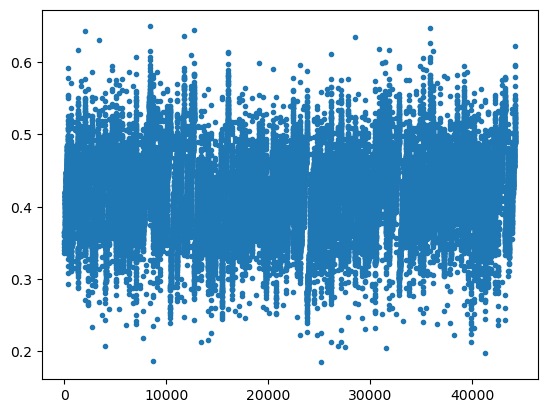

In [79]:
plt.plot(all_scores, '.')
plt.show()

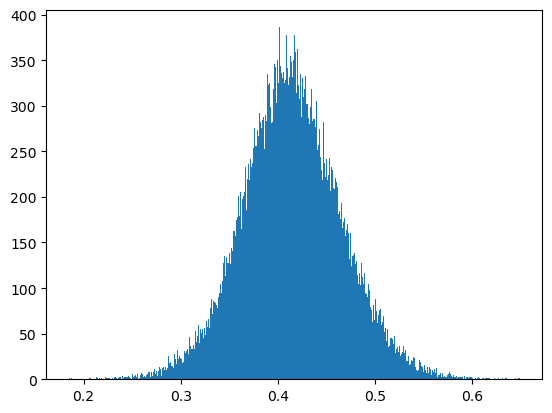

In [80]:
plt.hist(all_scores, bins = 500)
plt.show()

In [81]:
all_scores.sort()

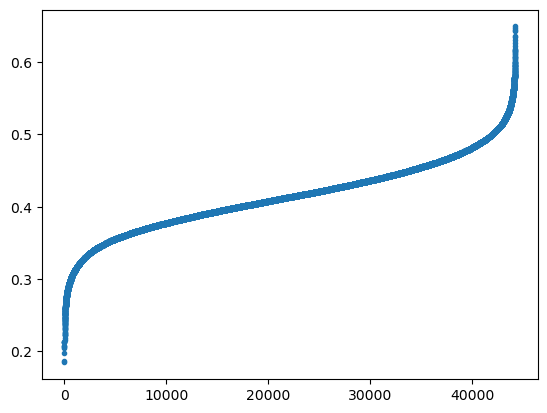

In [82]:
plt.plot(all_scores, '.')
plt.show()

In [83]:
all_scores[661]

0.301702082157135

In [86]:
for k,v in questions_with_scores.items():
    print (min(v))

0.3357967138290405
0.2933959662914276
0.3106028735637665
0.3156086206436157
0.2875020205974579
0.332031786441803
0.27159371972084045
0.26419851183891296
0.23360855877399445
0.2901632785797119
0.2680782377719879
0.2498420774936676
0.20737075805664062
0.25830164551734924
0.3244495987892151
0.278247207403183
0.259143590927124
0.3104085624217987
0.23683437705039978
0.2789846658706665
0.26706618070602417
0.2375992238521576
0.28785187005996704
0.21874213218688965
0.27974098920822144
0.26738810539245605
0.18706537783145905
0.24500639736652374
0.2853250205516815
0.3387227952480316
0.3360482454299927
0.23974770307540894
0.288867712020874
0.269411563873291
0.275770366191864
0.24700717628002167
0.3190944790840149
0.2864512801170349
0.24322539567947388
0.287564754486084
0.21377839148044586
0.3342511057853699
0.2161400467157364
0.22582954168319702
0.25953409075737
0.2783459424972534
0.2449566274881363
0.3285553455352783
0.2593536078929901
0.2723981738090515
0.25551357865333557
0.2500646710395813
0.